In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/raid/akshay/nano_models/') 

In [3]:
cd /raid/akshay/nano_models/modules/davit

/raid/akshay/nano_models/modules/davit


In [4]:
import sys
import os

# Get the current directory
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# Add the current directory to the beginning of sys.path
# This ensures your local modules are found before installed packages
sys.path.insert(0, current_dir)

# Verify the path
print(f"Updated Python path: {sys.path}")

# Now import from your local timm
from timm.models.davit_debug import DaViT_tiny, ChannelAttention, WindowAttention, SpatialBlock, ChannelBlock


Current directory: /raid/akshay/nano_models/modules/davit
Updated Python path: ['/raid/akshay/nano_models/modules/davit', '/raid/akshay/miniconda3/envs/qclip/lib/python310.zip', '/raid/akshay/miniconda3/envs/qclip/lib/python3.10', '/raid/akshay/miniconda3/envs/qclip/lib/python3.10/lib-dynload', '', '/raid/akshay/miniconda3/envs/qclip/lib/python3.10/site-packages', '/raid/akshay/medclip_training', '/raid/akshay/nano_models/']



=== Testing Patch Embedding ===

=== Input Image ===
Shape: torch.Size([1, 3, 224, 224])
Type: torch.float32
Min/Max/Mean: -4.1974/4.2017/0.0064


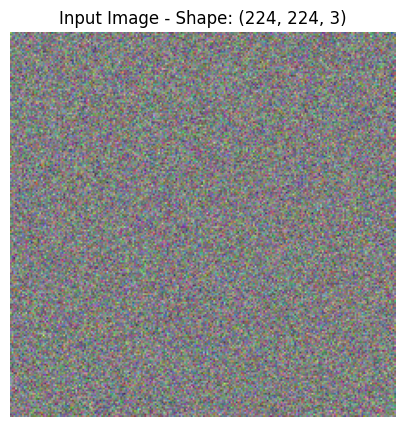

Applying patch embedding...
[PatchEmbed] Input image shape: torch.Size([1, 3, 224, 224]) (B, C, H, W)
[PatchEmbed] After projection: torch.Size([1, 96, 56, 56]) (B, embed_dim, H', W')
[PatchEmbed] New spatial size: (56, 56)
[PatchEmbed] After flattening spatial dims: torch.Size([1, 96, 3136])
[PatchEmbed] After transposing to (B, N, C): torch.Size([1, 3136, 96])
[PatchEmbed] After final norm: torch.Size([1, 3136, 96])
Output shape: torch.Size([1, 3136, 96])
Output size: (56, 56)
Number of tokens: 3136
Token dimension: 96
Expected number of tokens: 3136 (= 56×56)
Token grid shape: torch.Size([56, 56, 96])

=== Testing Window Partitioning ===
Input shape: torch.Size([1, 56, 56, 96])
[window_partition] Input shape: torch.Size([1, 56, 56, 96]) (B, H, W, C)
[window_partition] After reshaping into windows: torch.Size([1, 8, 7, 8, 7, 96]) (B, H//ws, ws, W//ws, ws, C)
[window_partition] After permuting: torch.Size([1, 8, 8, 7, 7, 96]) (B, H//ws, W//ws, ws, ws, C)
[window_partition] Final windo

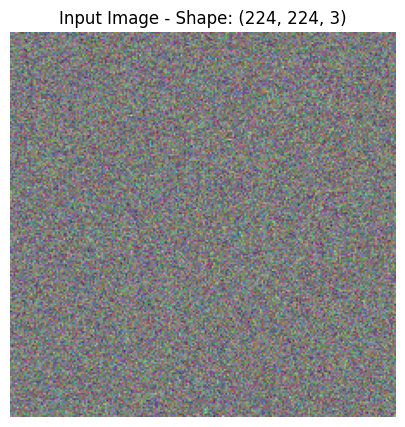

TESTING COMPLETE FLOW
[PatchEmbed] Input image shape: torch.Size([1, 3, 224, 224]) (B, C, H, W)
[PatchEmbed] After projection: torch.Size([1, 96, 56, 56]) (B, embed_dim, H', W')
[PatchEmbed] New spatial size: (56, 56)
[PatchEmbed] After flattening spatial dims: torch.Size([1, 96, 3136])
[PatchEmbed] After transposing to (B, N, C): torch.Size([1, 3136, 96])
[PatchEmbed] After final norm: torch.Size([1, 3136, 96])
[SpatialBlock] Input shape: torch.Size([1, 3136, 96]), size: (56, 56)
[SpatialBlock] After reshape to spatial: torch.Size([1, 56, 56, 96])
[SpatialBlock] After padding: torch.Size([1, 56, 56, 96]), padded to (56, 56)
[window_partition] Input shape: torch.Size([1, 56, 56, 96]) (B, H, W, C)
[window_partition] After reshaping into windows: torch.Size([1, 8, 7, 8, 7, 96]) (B, H//ws, ws, W//ws, ws, C)
[window_partition] After permuting: torch.Size([1, 8, 8, 7, 7, 96]) (B, H//ws, W//ws, ws, ws, C)
[window_partition] Final windows shape: torch.Size([64, 7, 7, 96]) (B*num_windows, ws, 

In [5]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# Add current directory to path to use local timm
current_dir = os.getcwd()
sys.path.insert(0, current_dir)

# Import from local timm
from timm.models.davit_debug import (
    DaViT_tiny, ChannelAttention, WindowAttention, 
    SpatialBlock, ChannelBlock, PatchEmbed,
    window_partition, window_reverse
)

def visualize_tensor(tensor, title, max_items=5):
    """Helper function to visualize tensor shapes and content"""
    print(f"\n=== {title} ===")
    print(f"Shape: {tensor.shape}")
    print(f"Type: {tensor.dtype}")
    print(f"Min/Max/Mean: {tensor.min().item():.4f}/{tensor.max().item():.4f}/{tensor.mean().item():.4f}")
    
    # For 4D image tensors, visualize a few channels
    if len(tensor.shape) == 4 and tensor.shape[1] <= 3:
        # Convert tensor to numpy for visualization
        img = tensor[0].permute(1, 2, 0).detach().cpu().numpy()
        # Normalize to [0, 1] for visualization
        img = (img - img.min()) / (img.max() - img.min())
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.title(f"{title} - Shape: {img.shape}")
        plt.axis('off')
        plt.show()

def test_patch_embed():
    """Test the patch embedding process"""
    print("\n=== Testing Patch Embedding ===")
    
    # Create a dummy input image (1, 3, 224, 224)
    x = torch.randn(1, 3, 224, 224)
    visualize_tensor(x, "Input Image")
    
    # Create patch embedding layer
    patch_embed = PatchEmbed(patch_size=4, in_chans=3, embed_dim=96)
    
    # Forward pass
    print("Applying patch embedding...")
    x, size = patch_embed(x, (x.size(2), x.size(3)))
    
    print(f"Output shape: {x.shape}")
    print(f"Output size: {size}")
    print(f"Number of tokens: {x.shape[1]}")
    print(f"Token dimension: {x.shape[2]}")
    
    # Calculate theoretical values
    H, W = 224, 224
    P = 4  # patch size
    expected_tokens = (H // P) * (W // P) # basically it will be 224/4, 224/4 , 3*
    print(f"Expected number of tokens: {expected_tokens} (= {H//P}×{W//P})")
    
    # Visualize a few token embeddings
    token_grid = x[0].view(H//P, W//P, -1)
    print(f"Token grid shape: {token_grid.shape}")
    
    return x, size

def test_window_partition():
    """Test the window partitioning process"""
    print("\n=== Testing Window Partitioning ===")
    
    # Create a dummy feature map (B, H, W, C)
    B, H, W, C = 1, 56, 56, 96
    x = torch.randn(B, H, W, C)
    print(f"Input shape: {x.shape}")
    
    # Apply window partitioning
    window_size = 7
    windows = window_partition(x, window_size)
    print(f"After window_partition: {windows.shape}")
    
    # Calculate theoretical values
    num_windows = (H // window_size) * (W // window_size)
    print(f"Number of windows: {num_windows} (= {H//window_size}×{W//window_size})")
    print(f"Window size: {window_size}×{window_size}")
    
    # Visualize the first window
    first_window = windows[0].detach().cpu().numpy()
    print(f"First window shape: {first_window.shape}")
    
    # Reverse the window partitioning
    x_reversed = window_reverse(windows, window_size, H, W)
    print(f"After window_reverse: {x_reversed.shape}")
    
    # Check if the reverse operation is correct
    is_equal = torch.allclose(x, x_reversed, rtol=1e-5, atol=1e-5)
    print(f"Reverse operation successful: {is_equal}")
    
    return windows

def test_channel_attention():
    """Test the channel attention mechanism"""
    print("\n=== Testing Channel Attention ===")
    
    # Create a dummy input (B, N, C)
    B, N, C = 1, 3136, 96  # 3136 = 56*56 tokens
    x = torch.randn(B, N, C)
    print(f"Input shape: {x.shape}")
    
    # Create channel attention module
    channel_attn = ChannelAttention(dim=C, num_heads=3)
    
    # Forward pass
    out = channel_attn(x)
    print(f"Output shape: {out.shape}")
    
    # Explain the attention mechanism
    print("\nChannel Attention Mechanism:")
    print("1. Projects input to Q, K, V using a linear layer")
    print("2. Reshapes to separate heads")
    print("3. Computes attention as (K.T @ V) @ Q.T instead of standard (Q @ K.T) @ V")
    print("4. This focuses on channel relationships rather than spatial relationships")
    
    return out

def test_spatial_attention():
    """Test the spatial (window) attention mechanism"""
    print("\n=== Testing Spatial (Window) Attention ===")
    
    # Create a dummy input for a single window (B_, N, C)
    B_, N, C = 64, 49, 96  # 64 windows, 49 = 7*7 tokens per window
    x = torch.randn(B_, N, C)
    print(f"Input shape: {x.shape}")
    
    # Create window attention module
    window_attn = WindowAttention(dim=C, window_size=(7, 7), num_heads=3)
    
    # Forward pass
    out = window_attn(x)
    print(f"Output shape: {out.shape}")
    
    # Explain the attention mechanism
    print("\nSpatial (Window) Attention Mechanism:")
    print("1. Projects input to Q, K, V using a linear layer")
    print("2. Reshapes to separate heads")
    print("3. Computes standard self-attention: (Q @ K.T) @ V")
    print("4. This captures spatial relationships within each local window")
    
    return out

def test_full_block_flow():
    """Test the flow through a complete spatial and channel block"""
    print("\n=== Testing Complete Block Flow ===")
    
    # Create dummy input (B, N, C)
    B, N, C = 1, 3136, 96  # 3136 = 56*56 tokens
    x = torch.randn(B, N, C)
    size = (56, 56)  # H, W
    
    # Create blocks
    channel_block = ChannelBlock(dim=C, num_heads=3)
    spatial_block = SpatialBlock(dim=C, num_heads=3, window_size=7)
    
    # Forward pass through spatial block
    print("\nSpatial Block Flow:")
    x_spatial, size_spatial = spatial_block(x, size)
    print(f"Spatial block output shape: {x_spatial.shape}, size: {size_spatial}")

    # Forward pass through channel block
    print("\nChannel Block Flow:")
    x_channel, size_channel = channel_block(x, size)
    print(f"Channel block output shape: {x_channel.shape}, size: {size_channel}")
    
    
    
    
    return x_channel, x_spatial

def test_full_model():
    """Test the full DaViT model with a dummy image"""
    print("\n=== Testing Full DaViT Model ===")
    
    # Create a small DaViT model
    model = DaViT_tiny()
    model.eval()
    
    # Create a dummy input
    x = torch.randn(1, 3, 224, 224)
    visualize_tensor(x, "Input Image")
    print("TESTING COMPLETE FLOW")
    
    # Forward pass
    with torch.no_grad():
        output = model(x)
    
    print(f"Final output shape: {output.shape}")
    print(f"Number of classes: {output.shape[1]}")
    
    # Print model architecture summary
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nModel Architecture:")
    print(f"Total parameters: {total_params:,}")
    
    # Print the first few stages
    print("\nModel Stages:")
    for i, embed_dim in enumerate(model.embed_dims):
        print(f"Stage {i}: Embedding dimension = {embed_dim}")
    
    return output

def main():
    """Run all tests"""
    # Test patch embedding
    tokens, size = test_patch_embed()
    
    # Test window partitioning
    windows = test_window_partition()
    
    # Test attention mechanisms
    channel_out = test_channel_attention()
    spatial_out = test_spatial_attention()
    
    # Test full blocks
    channel_block_out, spatial_block_out = test_full_block_flow()
    
    # Test full model
    model_out = test_full_model()
    
    print("\n=== All Tests Completed ===")

if __name__ == "__main__":
    main()

In [7]:
x = torch.randn(1, 3, 512, 512)
model = DaViT_tiny()
model.eval()
# Forward pass
with torch.no_grad():
    output = model(x)

{'patch_size': 4, 'window_size': 7, 'embed_dims': (96, 192, 384, 768), 'num_heads': (3, 6, 12, 24), 'depths': (1, 1, 3, 1), 'mlp_ratio': 4.0, 'overlapped_patch': False}
[PatchEmbed] Input image shape: torch.Size([1, 3, 512, 512]) (B, C, H, W)
[PatchEmbed] After projection: torch.Size([1, 96, 128, 128]) (B, embed_dim, H', W')
[PatchEmbed] New spatial size: (128, 128)
[PatchEmbed] After flattening spatial dims: torch.Size([1, 96, 16384])
[PatchEmbed] After transposing to (B, N, C): torch.Size([1, 16384, 96])
[PatchEmbed] After final norm: torch.Size([1, 16384, 96])
[SpatialBlock] Input shape: torch.Size([1, 16384, 96]), size: (128, 128)
[SpatialBlock] After reshape to spatial: torch.Size([1, 128, 128, 96])
[SpatialBlock] After padding: torch.Size([1, 133, 133, 96]), padded to (133, 133)
[window_partition] Input shape: torch.Size([1, 133, 133, 96]) (B, H, W, C)
[window_partition] After reshaping into windows: torch.Size([1, 19, 7, 19, 7, 96]) (B, H//ws, ws, W//ws, ws, C)
[window_partition

In [7]:
model = DaViT_tiny()

{'patch_size': 4, 'window_size': 7, 'embed_dims': (96, 192, 384, 768), 'num_heads': (3, 6, 12, 24), 'depths': (1, 1, 3, 1), 'mlp_ratio': 4.0, 'overlapped_patch': False}


In [8]:
model

DaViT(
  (patch_embeds): ModuleList(
    (0): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): PatchEmbed(
      (proj): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (2): PatchEmbed(
      (proj): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (3): PatchEmbed(
      (proj): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
      (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
  )
  (main_blocks): ModuleList(
    (0): ModuleList(
      (0): MySequential(
        (0): SpatialBlock(
          (cpe): ModuleList(
            (0-1): 2 x ConvPosEnc(
              (proj): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96)
            )
          )
          (nor

### Testing actual timm package davit

In [ ]:


import torch
import torch.nn.functional as F
from timm.models import davit_tiny

# Load DaViT Tiny
model = davit_tiny(pretrained=False)
model.eval()

# Dummy input image
x = torch.randn(1, 3, 224, 224)

# ----- Step 1: Stem Convolution -----
with torch.no_grad():
    x = model.stem(x)
    print("[Stem] Output Shape:", x.shape)

# Store intermediate outputs
features = x

# ----- Step 2: Pass through DaViT Stages -----
for stage_id, stage in enumerate(model.stages):
    print(f"\n[Stage {stage_id}] Input Shape: {features.shape}")

    # Downsampling if applicable
    if hasattr(stage, 'downsample'):
        features = stage.downsample(features)
        print(f"[Stage {stage_id}] After Downsample: {features.shape}")

    # Pass through all blocks in the stage
    for block_id, block in enumerate(stage.blocks):
        features = block(features)
        print(f"[Stage {stage_id}] After Block {block_id}: {features.shape}")

# ----- Step 3: Classification Head -----
with torch.no_grad():
    x = model.head(features)
    print("\n[Classifier Output] Logits:", x.shape)

# Summary
print("\nDaViT (Dual-Attention ViT) step-by-step walkthrough complete ✅")